<div style='background-image: url("header.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Tutorial by Mondaic</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">For Salvus version 2025.1.2</div>
        </div>
    </div>
</div>

# Lamb's problem

## Part 3 - Visualization and extensions

In this part, we'll take a look at other output options, visualize the entire wavefield and start exploring other types of sources and receivers.

In [1]:
%matplotlib inline

In [2]:
# This notebook will use this variable to determine which
# remote site to run on.
import os

SALVUS_FLOW_SITE_NAME = os.environ.get("macbook", "local")
PROJECT_DIR = "project"

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib

import salvus.namespace as sn
from salvus.project.tools.processing import block_processing
from salvus.toolbox.helpers.wavefield_output import (
    WavefieldOutput,
    wavefield_output_to_xarray,
)

print("Opening existing project.")
p = sn.Project(path=PROJECT_DIR)

--> Server: 'https://l.mondaic.com/licensing_server', User: 'salome.bachmann', Group: 'ETHZ_ERDW_EEG'.
--> Negotiating 1 license instance(s) for 'SalvusMesh' [license version 1.0.0] for 1 seconds ...
--> Success! [Total duration: 0.58 seconds]
Opening existing project.


Accordion(children=(HTML(value='\n                <head>\n                <style>\n                td {\n     …

We want to rerun `simulation_3`, but with volumetric output.
In addition to displacement, let's also output the spatial gradient of the displacement field, so we can compute derived quantities like the divergence or curl afterwards.

In [6]:
p.simulations.launch(
    ranks_per_job=2,
    site_name="macbook",
    events=p.events.list(),
    simulation_configuration="simulation_3",
    extra_output_configuration={
        "volume_data": {
            "sampling_interval_in_time_steps": 10,
            "fields": ["displacement", "gradient-of-displacement"],
        },
    },
    # We have previously simulated the same event but without
    # extra output. We have to thus overwrite the existing
    # simulation.
    delete_conflicting_previous_results=True,
)

[2025-12-11 15:47:36,424] INFO: delete_conflicting_previous_results is set to True. Deleting results for simulation configuration simulation_3 and event event_0.
[2025-12-11 15:47:36,426] INFO: Removing contents of `project/EVENTS/event_0/WAVEFORM_DATA/INTERNAL/55/11/abcfd69ba132`.
[2025-12-11 15:47:36,442] INFO: Submitting job ...
Uploading 1 files...

🚀  Submitted job_2512111547493164_e976285102@macbook


1

And that's it! The simulations are off and running. Salvus<i>Flow</i> will take care of abstracting the machine archcitecture, and Salvus<i>Project</i> will take care of saving all the output data into the correct location, copying it from any remote machines as necessary. We can get the current status of the simulations by calling `query_simulations()` as below.

In [7]:
p.simulations.query(block=True)

VBox()

True

## Visualizing in Paraview

The jupyter widgets are great to get a glimpse of many entities. However, more advanced visualization requires external tools such as Paraview.

Meshes and wavefield data are read and written as HDF5 files. The HDF5 library allows us to performantly access single files in parallel, as well as allowing for the portable sharing of such files. To see a visual representation of what's in these files we recommend using Paraview.

Note that we strongly recommend to download Paraview from the official website -- the versions installed through Linux package management systems often do not come with the correct libraries installed.

Files are visualized in Paraview using the XDMF standard. This is why you'll see for every mesh, surface, or volume output file used by Salvus, an associated file with the same name but with a .xdmf file suffix.

You can query the internal folder where the output is stored with the following command.

In [8]:
p.simulations.get_simulation_output_directory(
    simulation_configuration="simulation_3", event=p.events.list()[0]
)

PosixPath('project/EVENTS/event_0/WAVEFORM_DATA/INTERNAL/55/11/abcfd69ba132')

In [9]:
# Uncomment the next line and paste the path from above
# !ls _paste_the_path_above_here

We see some log files, meta information, receiver data and volumetric output. The file `volume_data_output_elastic_volume.xdmf` is what we are after. It is this .xdmf file that should be opened in Paraview. When you do open such a file, you should see a dialogue box to select the correct reader. Make sure to select the `XDMF Reader` and not any of the `Xdmf3Reader` or Paraview will crash immediately :-/

## Post-processing of receiver and wavefield output

If there is no time step explicitly provided in the `WaveformSimulationConfiguration`, Salvus will automatically compute a suitable time step for the simulation based on the CFL condition. This will typically heavily oversample the signal. For post-processing, however, it might be convenient to work with resampled data.

### Receiver output

In [10]:
ed = p.waveforms.get("simulation_3", p.events.list())

Currently, the event data object contains the raw simulation output using the sampling rate / time step of the simulation. We can print the receiver data to verify the number of samples and sampling rate for all traces.

In [11]:
print(
    ed[0].get_receiver_data(
        receiver_name="XX.REC1.", receiver_field="displacement"
    )
)

2 Trace(s) in Stream:
XX.REC1..X | 1969-12-31T23:59:59.920000Z - 1970-01-01T00:00:00.600000Z | 1038.2 Hz, 707 samples
XX.REC1..Y | 1969-12-31T23:59:59.920000Z - 1970-01-01T00:00:00.600000Z | 1038.2 Hz, 707 samples




The event data object allows us to define a custom time interval and sampling rate to resample all traces on-the-fly. To this end, we first specify the desired time discretization. Any subsequent calls quereing data from the `EventData` object will then work with re-sampled data. For example, we can extract 250 samples at a sampling rate of 500 Hz starting from time zero as follows:

In [12]:
ed[0].set_temporal_interpolation(
    start_time_in_seconds=0.0, sampling_rate_in_hertz=500, npts=250
)

Retrieving the receiver data again now shows the desired sampling rate.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


2 Trace(s) in Stream:
XX.REC1..X | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:00.498000Z | 500.0 Hz, 250 samples
XX.REC1..Y | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:00.498000Z | 500.0 Hz, 250 samples


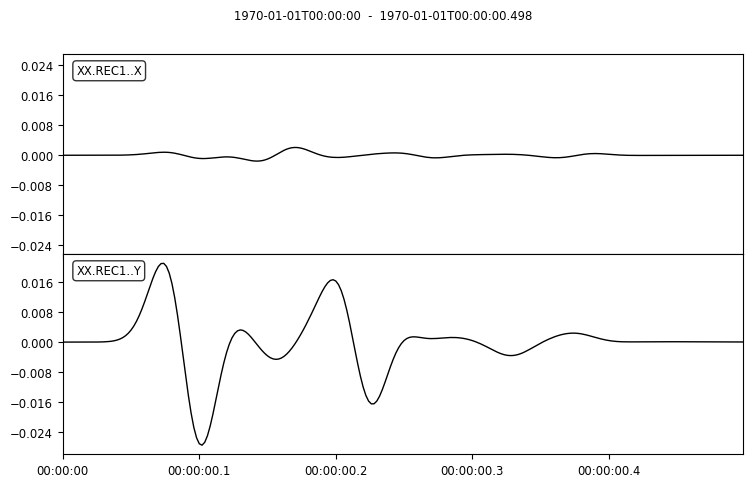

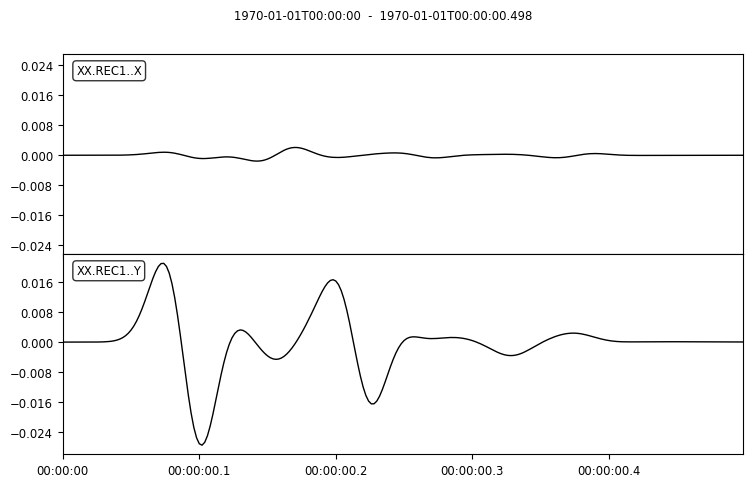

In [13]:
print(
    ed[0].get_receiver_data(
        receiver_name="XX.REC1.", receiver_field="displacement"
    )
)
ed[0].get_receiver_data(
    receiver_name="XX.REC1.", receiver_field="displacement"
).plot()

`get_receiver_data` returns an obspy stream object containing a list of traces. You can access individual traces by index and the raw data by the member `data`, which is a numpy array. Here, we query the `Y` component at index `1`.

In [14]:
trace_data = (
    ed[0]
    .get_receiver_data(
        receiver_name="XX.REC1.", receiver_field="displacement"
    )[1]
    .data
)
print(type(trace_data), trace_data.shape)

<class 'numpy.ndarray'> (250,)


Alternatively, you can retrieve the resampled data of all receivers for a single component.
Note that you can pass an additional sorting routine to `get_data_cube` in case you seek to obtain the receivers in a certain order. The function returns a tuple of the time axis as 1D array, and receiver data as 2D array `(nrec x nt)`. There is also the option to sort the receivers in case a certain order is desired.

In [15]:
times, values = ed[0].get_data_cube(
    receiver_field="displacement", component="Y"
)

/var/folders/5f/g3nknsgx6q3f91j5rd12vp240000gn/T/ipykernel_5060/628738622.py:1: DeprecationWarning: The method get_data_cube is deprecated and superseded by `get_waveform_data_xarray`. On xarray.DataArray, one can naturally apply selections, filters and sorting. The `get_data_cube` method will be removed in a future release.
  times, values = ed[0].get_data_cube(


Both functions return the same data, obviously.

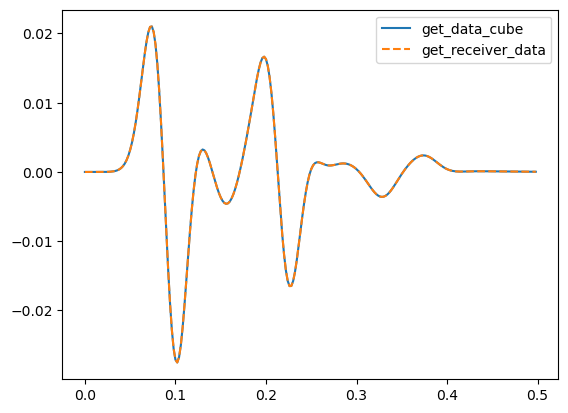

In [16]:
plt.plot(times, values[0, :], label="get_data_cube")
plt.plot(times, trace_data, "--", label="get_receiver_data")
plt.legend()
plt.show()

### Volumetric output

For volumetric wavefield output, we additionally have to deal with the complexity of the spatial discretization. Salvus uses unstructured meshes, but it might be desirable to obtain the wavefield output on a regular grid or at a predefined set of points. This kind of post-processing is possible with the `WavefieldOutput` object.

In [17]:
# First, retrieve the volumetric output file
output_file = pathlib.Path(
    p.simulations.get_simulation_output_directory("simulation_3", "event_0"),
    "volume_data_output.h5",
)

# Create a WavefieldOutput object for resampling
volume_output = WavefieldOutput.from_file(
    output_file, "displacement", "volume"
)

Now, we resample the volumetric wavefield output. The output is an `xarray.DataArray` with dimensions for
time, components and the array of points provided. The second argument can be an arbitrary array of points.
Here, we just use the coordinates of the points in the mesh.

In [18]:
sampled_output_1 = wavefield_output_to_xarray(
    volume_output, p.simulations.get_mesh("simulation_3").points
).T

Finding enclosing elements (pass 1 of auto):   0%|          | 0/6498 [00:00<?, ?it/s]

Extracting wavefield to regular grid:   0%|          | 0/4 [00:00<?, ?it/s]

For output on a regular grid, we can alternatively provide the sampling along each coordinate axis as a list.
For instance, we can sample on a regular grid in `x` and `y` with 10 m spacing.


In [19]:
sampled_output_2 = wavefield_output_to_xarray(
    volume_output,
    [
        np.linspace(0.0, 2000.0, 200),
        np.linspace(0.0, 1000.0, 100),
    ],
).T

Finding enclosing elements (pass 1 of auto):   0%|          | 0/20000 [00:00<?, ?it/s]

Extracting wavefield to regular grid:   0%|          | 0/5 [00:00<?, ?it/s]

We can now easily plot a snapshot of the wavefield using the built-in routines of `xarray`.

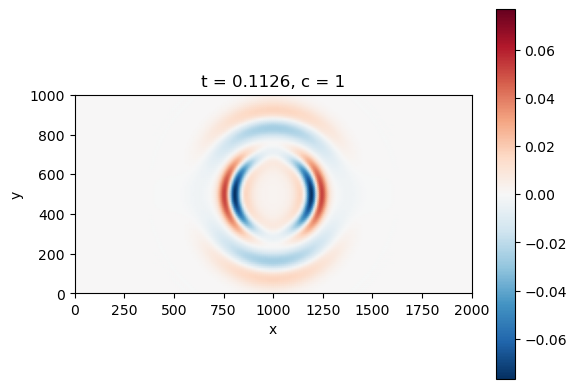

In [20]:
ax = sampled_output_2.sel(c=1, t=sampled_output_2.t[20]).plot(
    shading="gouraud", infer_intervals=False
)
ax.axes.set_aspect("equal")

As a final step of post-processing, we want to resample the volumetric output in time. There is currently no unified interface to do that, but you could manually achieve it with the following snippet.

In [21]:
resampled_output = block_processing.resample(
    sampled_output_1.data, sampled_output_1.t.data, np.linspace(0.0, 0.5, 251)
)

## Exercise

Now, it's time to play around with Salvus.

How about adding a new event with a moment tensor point source and strain receivers?
Have a look at the beginning of part one and try to create `event_1` with newly defined source(s) and receivers.

You could also ramp up the frequency and send some simulations to a bigger machine. Once you have registered a site with  Salvus<i>Flow</i>, you only need to adjust the `site_name` and the `ranks_per_job` in the `launch` function and Salvus will take care about the rest.


[2025-12-11 16:58:46,133] INFO: An event with name 'event_ex' and identical content already exists in the project. Nothing will be done.


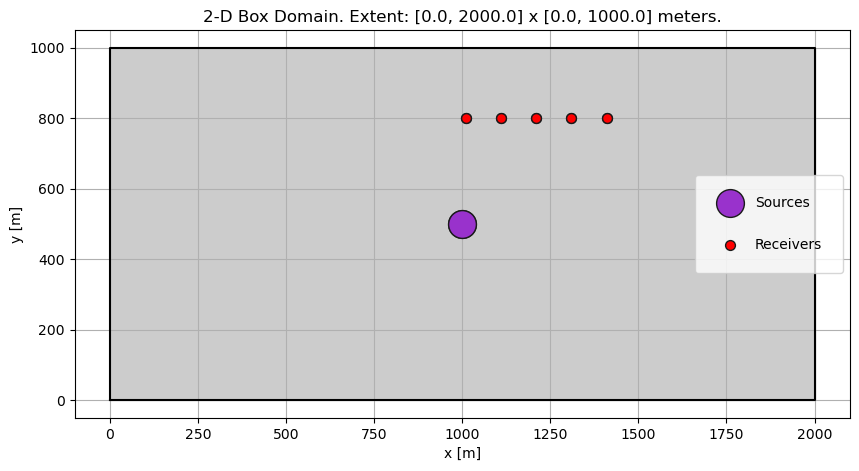

In [ ]:
# Creating a new event with moment tensor point source and strain recievers

# Sources from part 1 of the tutorial, changing the type of surce from the options in salvus docs
src = sn.simple_config.source.cartesian.MomentTensorPoint2D(
    x=1000.0, y=500.0, mxx = 1000, myy = -1000, mxy = 50 # See docs for the required parameters and their meaning 
)

# Recievers, changing thne type of reciever to strain recievers
recs = [
    sn.simple_config.receiver.cartesian.Point2D(
        y=800.0,
        x=x,
        network_code="XX",
        station_code=f"REC{i + 1}",
        fields=["strain"],
    )
    for i, x in enumerate(np.linspace(1010.0, 1410.0, 5))
]

# Running the simulation iwth the new event
p.add_to_project(sn.Event(event_name="event_ex", sources=src, receivers=recs))

# Plotting 
p.viz.nb.domain()

# Defining the model
mc = sn.ModelConfiguration(
    background_model=sn.model.background.homogeneous.IsotropicElastic(
        rho=2200.0, vp=3200.0, vs=1847.5
    )
)


ec = sn.EventConfiguration(
    wavelet=sn.simple_config.stf.Ricker(center_frequency=14.5),
    waveform_simulation_configuration=sn.WaveformSimulationConfiguration(
        start_time_in_seconds=-0.08,
        end_time_in_seconds=0.6,
    ),
)

p.add_to_project(
    sn.SimulationConfiguration(
        name="exercise_simulation",
        max_frequency_in_hertz=30.0,
        elements_per_wavelength=1.0,
        model_configuration=mc,
        event_configuration=ec,
    )
)

